In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def plot_mnist(images, shape):
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()

In [3]:
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])
path = './MNIST_data'
batch_size = 50

In [4]:
test_data = datasets.MNIST(path, train=False,
                           download=True, transform=mnist_transform)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

train_data = datasets.MNIST(path, train=True,
                            download=True, transform=mnist_transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [5]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, latent_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 128)
        self.fc2 = nn.Linear(128, 28*28)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        return x

In [6]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        _loss = self.loss_fn(x, target, **kwargs)
        self._loss = _loss.item()
        return _loss

In [7]:
models = {'16': Net(16), '32': Net(32), '64': Net(64)}

In [8]:
def train(epoch, models):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss) for k, m in models.items()])
        print(line + losses)

In [9]:
line = lambda i, l: 'loss_{}: {:.4f}'.format(i, l)
    
def test(models, loader):
    test_size = len(loader.sampler)
    test_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, reduction='sum').item() # sum up batch loss
    
    for k in models:
        test_loss[k] /= (test_size * 784)
    
    lines = '\n'.join([line(k, test_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [10]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models)
    for model in models.values():
        model.eval()
    test(models, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Losses 16: 0.922233 32: 0.939616 64: 0.939889
Train Epoch: 1 [10000/60000 (17%)]	Losses 16: 0.256355 32: 0.254155 64: 0.251377
Train Epoch: 1 [20000/60000 (33%)]	Losses 16: 0.219335 32: 0.215211 64: 0.206577
Train Epoch: 1 [30000/60000 (50%)]	Losses 16: 0.189027 32: 0.175547 64: 0.156999
Train Epoch: 1 [40000/60000 (67%)]	Losses 16: 0.167420 32: 0.153364 64: 0.136789
Train Epoch: 1 [50000/60000 (83%)]	Losses 16: 0.154644 32: 0.141209 64: 0.126193
Train Epoch: 1 [60000/60000 (100%)]	Losses 16: 0.156359 32: 0.134652 64: 0.120912
Test set:
loss_16: 0.1450
loss_32: 0.1241
loss_64: 0.1111

Train Epoch: 2 [0/60000 (0%)]	Losses 16: 0.128495 32: 0.111409 64: 0.101216
Train Epoch: 2 [10000/60000 (17%)]	Losses 16: 0.140599 32: 0.113538 64: 0.104704
Train Epoch: 2 [20000/60000 (33%)]	Losses 16: 0.131179 32: 0.105035 64: 0.094982
Train Epoch: 2 [30000/60000 (50%)]	Losses 16: 0.135239 32: 0.102930 64: 0.091830
Train Epoch: 2 [40000/60000 (67%)]	Losses 16: 0.134408 32: 

In [11]:
data, _ = next(iter(test_loader))
with torch.no_grad():
    outputs = {k: models[k](data).view(-1, 1, 28, 28).data.numpy() for k in models}
data = data.view(-1, 1, 28, 28).data.numpy()

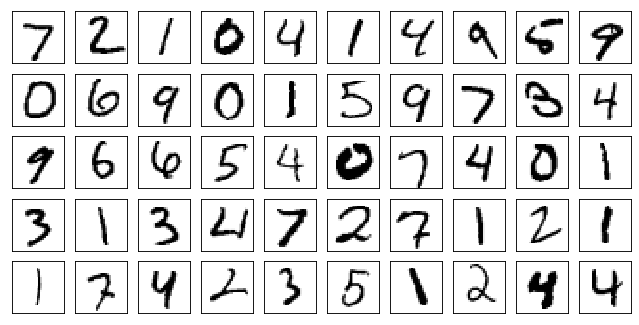

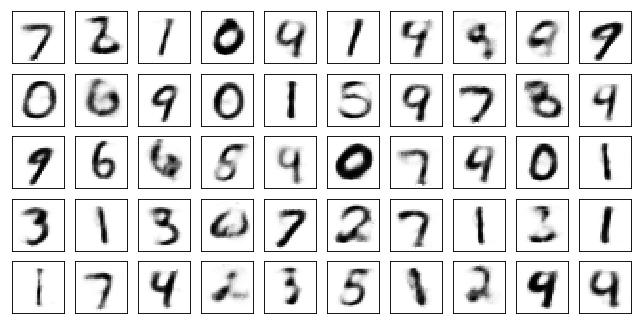

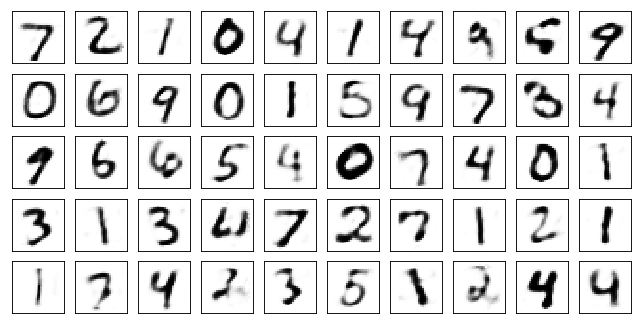

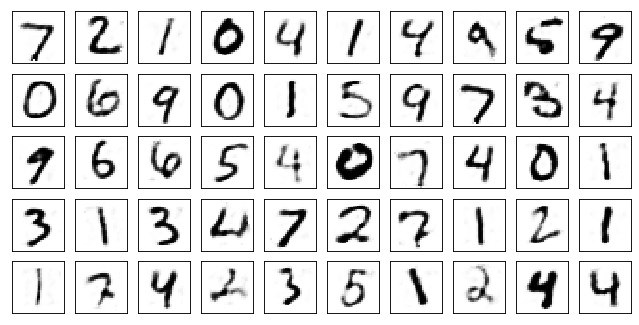

In [12]:
plot_mnist(data, (5, 10))
plot_mnist(outputs['16'], (5, 10))
plot_mnist(outputs['32'], (5, 10))
plot_mnist(outputs['64'], (5, 10))